In [12]:
# This are the dependencies required for the project

!pip install collatex
!pip install graphviz
!pip install levenshtein
!pip install xmltodict
!pip install beautifulsoup4
!pip install lxml
!pip install textdistance
!pip install pandas
!pip install matplotlib
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 KB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 75.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 5.3 MB/s eta 0:00:00a 0:00:01


This markdown portion is to introduce you the the current implementation details.

The code below assumes that the pre-processed XML to be available in the same folder as of the .ipynb file running from.
This is something that can be fixed in the near future.

The current implementation details are as follows:

First Part:
It parses the XML files to extract the chapter information and the verse number information. Once the data is arranged we generate the witness

Second Part:
The verses are arranged as an input to the collatex tool for further analysis


In [3]:
# See if beautiful soup can be of any use
# This part of the code is clunky but it is what it is

# Implementation of the first part
from itertools import combinations
from bs4 import BeautifulSoup
import re

fileNames = ["ms_a_new.xml","ms_b_new.xml","ms_d_new.xml","ms_e_new.xml","ms_f_new.xml"]
soup = dict()
chapter = dict()
verse_list = dict()
verses = dict()

for currFile in fileNames:
    with open(currFile,encoding="utf8") as fp:
        soup[currFile] = BeautifulSoup(fp,features='xml')
        chs = list()
        verse_list[currFile] = dict()
        verses[currFile] =dict()
        for i in soup[currFile].findAll("chap"):
            ch_string=i.contents[0].strip()
            chs.append(ch_string) # strip to remove trailing spaces or new line characters
            verses_list = list()
            verse = i.findAll("text")
            verses[currFile][ch_string] = dict()
            for verse_iter in verse:
                if verse_iter.verse_nb:
                    verse_num=verse_iter.verse_nb.text.strip()
                verses_list.append(verse_num)
                """
                <!ELEMENT folio (#PCDATA)> <!-- shelfmark of the manuscript and folio number -->
                <!ELEMENT verse_nb (#PCDATA)> <!-- verse (children of chapter) -->
                <!ELEMENT line (#PCDATA)> <!-- line on the manuscript -->
                <!ELEMENT vacat_car (#PCDATA)> <!-- a space into the manuscript -->
                <!ELEMENT greek (#PCDATA)> <!-- greek word or letter -->
                <!ELEMENT reconstructed (#PCDATA)> <!-- Hebrew reconstructed -->
                <!ELEMENT superscript (#PCDATA)> <!-- Hebrew superscript letters or words -->
                <!ELEMENT supralinear (#PCDATA)> <!-- Hebrew supralinear letters or words (I think = superscript) -->
                <!ELEMENT margin_reconstructed (#PCDATA)> <!-- marginal notation reconstructed -->
                <!ELEMENT margin_car (#PCDATA)> <!-- marginal notation -->
                <!ELEMENT margin_infralinear (#PCDATA)> <!-- marginal notation -->
                <!ELEMENT margin_supralinear (#PCDATA)> <!-- marginal notation -->
                """
                # For now clean the text which might be enclosed in the tags
                unwanted_tags= ["folio","verse_nb","line","vacat_car","greek","reconstructed","superscript",\
                "supralinear","margin_reconstructed","margin_car","margin_infralinear",\
                "margin_supralinear","Article"]
                
                # Clean tags
                [s.extract() for s in verse_iter(unwanted_tags)]
                
                # FileName will never be empty
                if (ch_string and verse_num):
                    verses[currFile][ch_string][verse_num] = verse_iter.text.replace("[","").replace("]","")
            verse_list[currFile][ch_string]=verses_list
        
        chapter[currFile] = chs
        #verse = chapter[currFile].findAll("text")
        #for i in verse:
            #print(i.verse_nb.text)
            #print(i.contents)
            #ls = [type(item) for item in i.contents]
            #print(ls)
            #print("\n")


#print(soup['ms_d_new.xml'].findAll("chap")[0].contents[0])



# Implementation of the second part
# Building the combinations
chap_matching = dict()
witnesses = dict()
chap_info = dict()
count = 0
for combo in combinations(fileNames, 2):  # 2 for pairs, 3 for triplets, etc
    matching_chs_list = []
    if combo[0] in chap_matching.keys():
        pass
    else:
        chap_matching[combo[0]] = dict()
    for chap_in_file1 in chapter[combo[0]]:
        for chap_in_file2 in chapter[combo[1]]:
            ch1_num=re.findall(r'\b\d+\b', chap_in_file1)
            ch2_num=re.findall(r'\b\d+\b', chap_in_file2)
            if ch1_num == ch2_num:
                matching_chs_list.append([chap_in_file1,chap_in_file2]) 
                # Lets see if we can find common verses
                common_verses= set(verse_list[combo[0]][chap_in_file1]).intersection(verse_list[combo[1]][chap_in_file2])
                for com_verse in common_verses:
                    if com_verse:
                        witnesses[count] = dict()
                        witnesses[count]['A'] = verses[combo[0]][chap_in_file1][com_verse]
                        witnesses[count]['B'] = verses[combo[1]][chap_in_file2][com_verse]
                        chap_info[count] = (combo[0],chap_in_file1,combo[1],chap_in_file2,com_verse)
                        count = count+1;
    chap_matching[combo[0]][combo[1]]=matching_chs_list
    

# Changing the witness variable here will change the verse which will be loaded for comaparison
witness_index=12
from collatex import *
collation = Collation()
collation.add_plain_witness("A", witnesses[witness_index]['A'])
collation.add_plain_witness("B", witnesses[witness_index]['B'])
print("\nManuscript A: "+witnesses[witness_index]['A'])
print("Manuscript B: "+witnesses[witness_index]['B']+"\n")
#alignment_table = collate(collation, segmentation=False)
#print(chap_matching)
#print(verses)
print(chap_info[witness_index])
alignment_table = collate(collation,output="svg")


            

Error: syntax error in line 1 
... <B></B> ...
in label of node 3



Manuscript A:  בְטֶ֥רֶם תַ֭חְקר̊ א‍ַל־תְסַלֵף	בַּקֵּרֽ לְ֜פָנִֹים וְאַחַ֥ר תַזִֿיֹֽׁף׃ 
Manuscript B:  ק̊̊ו̊̊ר אל תסלף	בקר לפנים וא֟חר̇ תזיף׃

('ms_a_new.xml', 'Chapter 11', 'ms_b_new.xml', 'Siracide 11', '7')


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'Digraph.gv']' returned non-zero exit status 1. [stderr: b'Error: syntax error in line 1 \n... <B></B> ...\nin label of node 3\n']

In [4]:
# This portion of the code attempts to compute the distances between different witnesses
# Lets find the number of witnesses

num_witnesses = len(witnesses)
# Lets create an empty dictionary to store the variants
variants = dict()
# For chapter information we can refer to the dictionary chap_info
# The dictionary indexes are same across all the data

# Lets loop of each witness
for witness_ind in range(num_witnesses):
    # Lets run the collation for each set of witnesses
    # Create empty dictionary for each element
    variants[witness_ind] = dict()
    variants[witness_ind]['A'] = '' # Empty initialisatiom
    variants[witness_ind]['B'] = ''
    collation = Collation()
    collation.add_plain_witness("A", witnesses[witness_ind]['A'])
    collation.add_plain_witness("B", witnesses[witness_ind]['B'])
    # Perform the collation
    alignment_table = collate(collation)
    # Lets start trying to find the variants
    for column in alignment_table.columns:
        if column.variant:
        # Add to variants the tokens as strings       
            for manuscript, tokens in column.tokens_per_witness.items():
                token_strings = [token.token_string for token in tokens]
                variants[witness_ind][manuscript] += ' '.join(token_strings)
                


In [6]:
# Lets begin to calculate the distances
import textdistance

# Lets iterate over the witnesses
# We begin by finding the number of witnesses we have
hamming_distances = dict()
print("---Computing hamming distances---")
for key in witnesses:
    text_distance = textdistance.hamming(variants[key]['A'],variants[key]['B'])
    hamming_distances[key] = text_distance

hamming_distances

---Computing hamming distances---


{0: 23,
 1: 17,
 2: 10,
 3: 28,
 4: 47,
 5: 28,
 6: 21,
 7: 20,
 8: 29,
 9: 50,
 10: 20,
 11: 26,
 12: 107,
 13: 60,
 14: 7,
 15: 28,
 16: 32,
 17: 90,
 18: 27,
 19: 40,
 20: 25,
 21: 13,
 22: 35,
 23: 30,
 24: 17,
 25: 16,
 26: 36,
 27: 23,
 28: 38,
 29: 22,
 30: 22,
 31: 24,
 32: 18,
 33: 17,
 34: 23,
 35: 29,
 36: 72,
 37: 38,
 38: 68,
 39: 22,
 40: 37,
 41: 30,
 42: 53,
 43: 15,
 44: 27,
 45: 18,
 46: 9,
 47: 55,
 48: 32,
 49: 24,
 50: 3,
 51: 25,
 52: 58,
 53: 26,
 54: 31,
 55: 40,
 56: 11,
 57: 11,
 58: 27,
 59: 64,
 60: 19,
 61: 22,
 62: 50,
 63: 63,
 64: 29,
 65: 10,
 66: 20,
 67: 40,
 68: 25,
 69: 49,
 70: 38,
 71: 34,
 72: 25,
 73: 39,
 74: 38,
 75: 10,
 76: 12,
 77: 89,
 78: 20,
 79: 13,
 80: 11,
 81: 93,
 82: 1,
 83: 38,
 84: 53,
 85: 7,
 86: 21,
 87: 64,
 88: 30,
 89: 11,
 90: 21,
 91: 30,
 92: 26,
 93: 21,
 94: 18,
 95: 11,
 96: 34,
 97: 10,
 98: 18,
 99: 76,
 100: 26,
 101: 24,
 102: 11,
 103: 30,
 104: 55,
 105: 34,
 106: 21,
 107: 35,
 108: 18,
 109: 18,
 110: 9,
 111:

In [7]:
# Lets begin to calculate the distances
import textdistance

# Lets iterate over the witnesses
# We begin by finding the number of witnesses we have
levenshtein_distances = dict()
print("---Computing levenshtein distances---")
for key in witnesses:
    text_distance = textdistance.levenshtein(variants[key]['A'],variants[key]['B'])
    levenshtein_distances[key] = text_distance

levenshtein_distances

---Computing levenshtein distances---


{0: 20,
 1: 11,
 2: 10,
 3: 19,
 4: 34,
 5: 20,
 6: 16,
 7: 16,
 8: 27,
 9: 35,
 10: 13,
 11: 21,
 12: 79,
 13: 41,
 14: 5,
 15: 13,
 16: 23,
 17: 77,
 18: 14,
 19: 19,
 20: 16,
 21: 12,
 22: 26,
 23: 27,
 24: 11,
 25: 14,
 26: 26,
 27: 14,
 28: 29,
 29: 16,
 30: 18,
 31: 18,
 32: 15,
 33: 16,
 34: 17,
 35: 22,
 36: 55,
 37: 21,
 38: 52,
 39: 20,
 40: 16,
 41: 21,
 42: 38,
 43: 14,
 44: 24,
 45: 17,
 46: 4,
 47: 37,
 48: 31,
 49: 21,
 50: 3,
 51: 20,
 52: 36,
 53: 18,
 54: 25,
 55: 26,
 56: 9,
 57: 6,
 58: 18,
 59: 42,
 60: 8,
 61: 11,
 62: 36,
 63: 47,
 64: 22,
 65: 7,
 66: 17,
 67: 28,
 68: 21,
 69: 36,
 70: 29,
 71: 31,
 72: 19,
 73: 32,
 74: 24,
 75: 6,
 76: 8,
 77: 59,
 78: 14,
 79: 7,
 80: 9,
 81: 71,
 82: 1,
 83: 31,
 84: 33,
 85: 7,
 86: 16,
 87: 48,
 88: 13,
 89: 8,
 90: 11,
 91: 27,
 92: 14,
 93: 12,
 94: 14,
 95: 5,
 96: 20,
 97: 7,
 98: 12,
 99: 60,
 100: 15,
 101: 13,
 102: 11,
 103: 12,
 104: 39,
 105: 30,
 106: 18,
 107: 28,
 108: 15,
 109: 10,
 110: 8,
 111: 16,
 112: 4

This part of the code is for the pre-processing part of the XML files to generate the ms_a_new.xml , ms_b_new.xml.

This is not the most efficiently way of implementing it, but this is for proof of concept which can be eventually made into a finer module

The code below is not automatic. The input and output filenames needs to be specified manually

In [13]:
# We import the chap_info variable into pandas
import pandas as pd
chap_info_df = pd.DataFrame.from_dict(chap_info,orient='index',columns=['Manuscript1','Chapter1','Manuscript2','Chapter2','Verse'])
# Strip ms_a and _new.xml from the manuscript
chap_info_df['Manuscript1'] = chap_info_df['Manuscript1'].str.replace('ms_','')
chap_info_df['Manuscript2'] = chap_info_df['Manuscript2'].str.replace('ms_','')
# Strip _new.xml from the manuscript filenames
chap_info_df['Manuscript1'] = chap_info_df['Manuscript1'].str.replace('_new.xml','')
chap_info_df['Manuscript2'] = chap_info_df['Manuscript2'].str.replace('_new.xml','')

# Add the distances to the dataframe
chap_info_df['Hamming'] = hamming_distances.values()
chap_info_df['Levenshtein'] = levenshtein_distances.values()
chap_info_df



,Manuscript1,Chapter1,Manuscript2,Chapter2,Verse,Hamming,Levenshtein
0,a,Chapter 10,b,Siracide 10,31,23,20
1,a,Chapter 10,b,Siracide 10,20,17,11
2,a,Chapter 10,b,Siracide 10,29,10,10
3,a,Chapter 10,b,Siracide 10,23,28,19
4,a,Chapter 10,b,Siracide 10,26,47,34
...,...,...,...,...,...,...,...
148,e,Chapter 33,f,Chapter 33,5,22,12
149,e,Chapter 33,f,Chapter 33,7,15,11
150,e,Chapter 33,f,Chapter 33,6,14,14
151,e,Chapter 33,f,Chapter 33,2,9,8


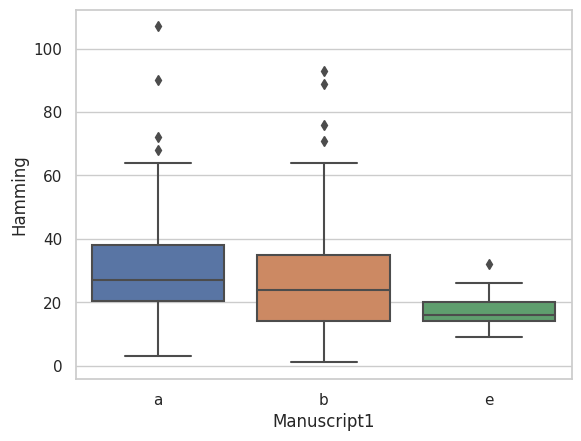

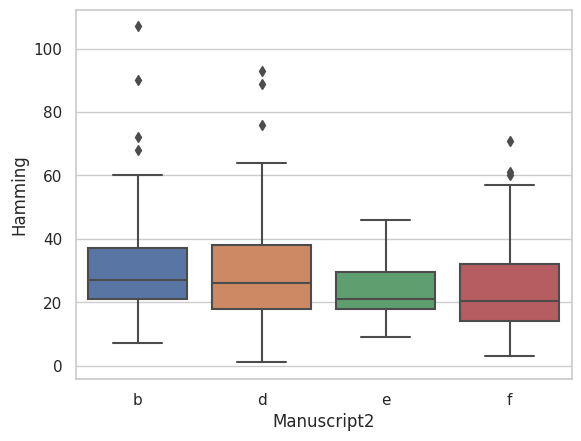

In [15]:
# Create boxplot for hamming distances for Manuscript1 and Manuscript2
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="Manuscript1", y="Hamming", data=chap_info_df)
plt.show()
ax = sns.boxplot(x="Manuscript2", y="Hamming", data=chap_info_df)
plt.show()


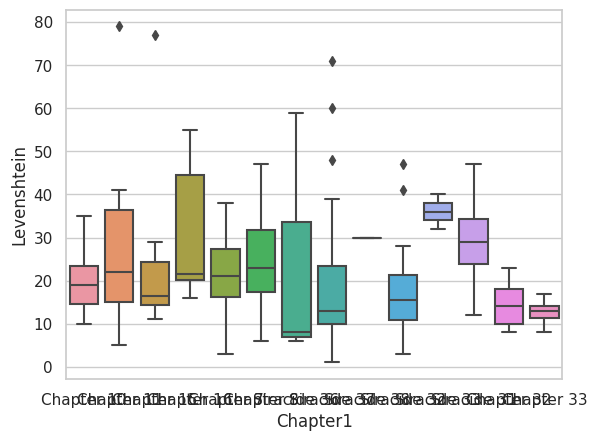

In [16]:
# Create boxplot for levenshtein distances based upon chapter
ax = sns.boxplot(x="Chapter1", y="Levenshtein", data=chap_info_df) 
plt.show()


In [ ]:
# This is building an alternate parser for the XML
# This block is meant for fixing the tags of the <chap>
# This block is for fixing the incorrect tag closing of <chap>
from lxml import etree
import json,re,xmltodict


# First load a document and find the number of chapters the file contains
with open("../data/ms_f.xml",encoding="utf8") as xml_file:

    #read content of file to string
    data = xml_file.read()
    #first replace </chap> with empty
    new_data=data.replace("</chap>","")
    #Then replace <chap> with </chap><chap>
    #Replace first occurrence to restore <chap>
    new_data1=new_data.replace("<chap>","</chap><chap>").replace("</chap><chap>","<chap>",1)
    # To compensate chapter closing replace </Article> with </chap></Article>
    # But this has to be the last occurence so we use rfind
    replacementStr="</chap></Article>"
    new_data1=replacementStr.join(new_data1.rsplit("</Article>", 1))

    #json_data = json.dumps(final_data,ensure_ascii=False,indent=1)
     
    # Write the json data to output
    # json file
    with open("ms_f_new.xml", "w", encoding="utf8") as json_file:
        json_file.write(new_data1)
        json_file.close()
